In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
%cat 0Source_Citation.txt

Source and citation

- This notebook is a part of the `pytheos` package.
- Website: http://github.com/SHDShim/pytheos.
- How to cite: S.-H. Shim (2017) Pytheos - a python tool set for equations of state. DOI: 10.5281/zenodo.802392


# 0. General note

- Even for the same data, Birch-Murnaghan equation and Vinet equation yield different $K_0$ and $K_0'$ values. 

- This notebook shows how to convert $K_0$ and $K'_0$ from the Vinet equation to the Birch-Murnaghan equation.

# 1. General setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pytheos as eos
import uncertainties as uct
from uncertainties import unumpy as unp

# 2. Vinet EOS

* source: Ye 2017, JGR

* Pt: $V_0 = 3.9231^3$ A$^{3}$, $K_0 = 277.3$ GPa, $K_0' = 5.226\pm 0.033$.  

* Au: $V_0 = 4.07860^3$ A$^{3}$, $K_0 = 167.0$ GPa, $K_0' = 5.813\pm 0.022$.  

* MgO: $V_0 = 74.698$ A$^{3}$, $K_0 = 160.3$ GPa, $K_0' = 4.109\pm 0.022$.  

In [5]:
v0 = {'Pt': 3.9231**3, 'Au': 4.07860**3, 'MgO': 74.698}
k0 = {'Pt': 277.3, 'Au': 167.0, 'MgO': 160.3}
k0p = {'Pt': uct.ufloat(5.226, 0.033), 'Au': uct.ufloat(5.813, 0.022), 'MgO': uct.ufloat(4.109, 0.022)}

Set pressure range and number of data points.

In [6]:
p_max = 150.
n_pts = 100
p = np.linspace(0.,p_max, n_pts)
standard = 'MgO'

Calculate volume of MgO at different pressures.

In [7]:
v = eos.vinet_v(p, v0[standard], k0[standard], k0p[standard])

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/hq/thm59xl964s5d51mg8d1jt1m0000gp/T/ipykernel_40011/257759462.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Unit-cell volume ($\mathrm{\AA}^3$)');


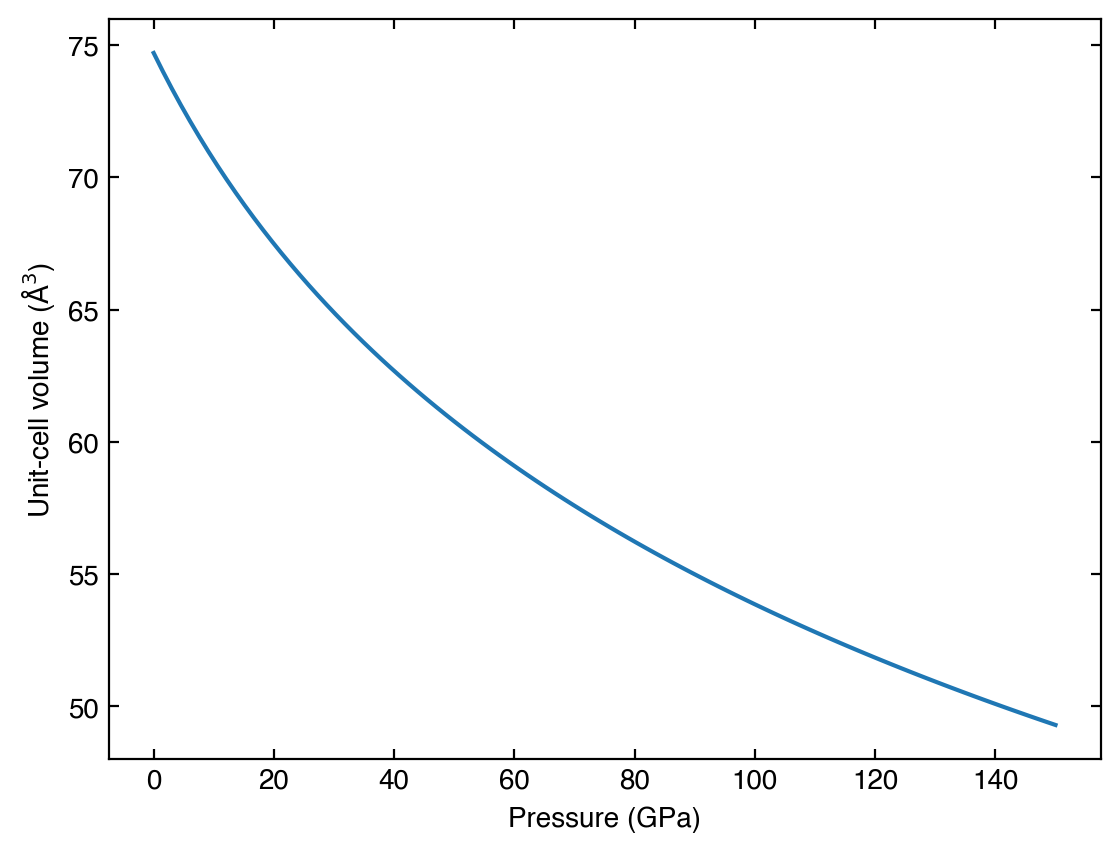

In [8]:
plt.plot(p,unp.nominal_values(v))
plt.xlabel('Pressure (GPa)')
plt.ylabel('Unit-cell volume ($\mathrm{\AA}^3$)');

# 3. What if you use those numbers for a wrong equation

In [9]:
v_bm3 = eos.bm3_v(p, v0[standard], k0[standard], k0p[standard])

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
/var/folders/hq/thm59xl964s5d51mg8d1jt1m0000gp/T/ipykernel_40011/3763908616.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta$ P (GPa)');


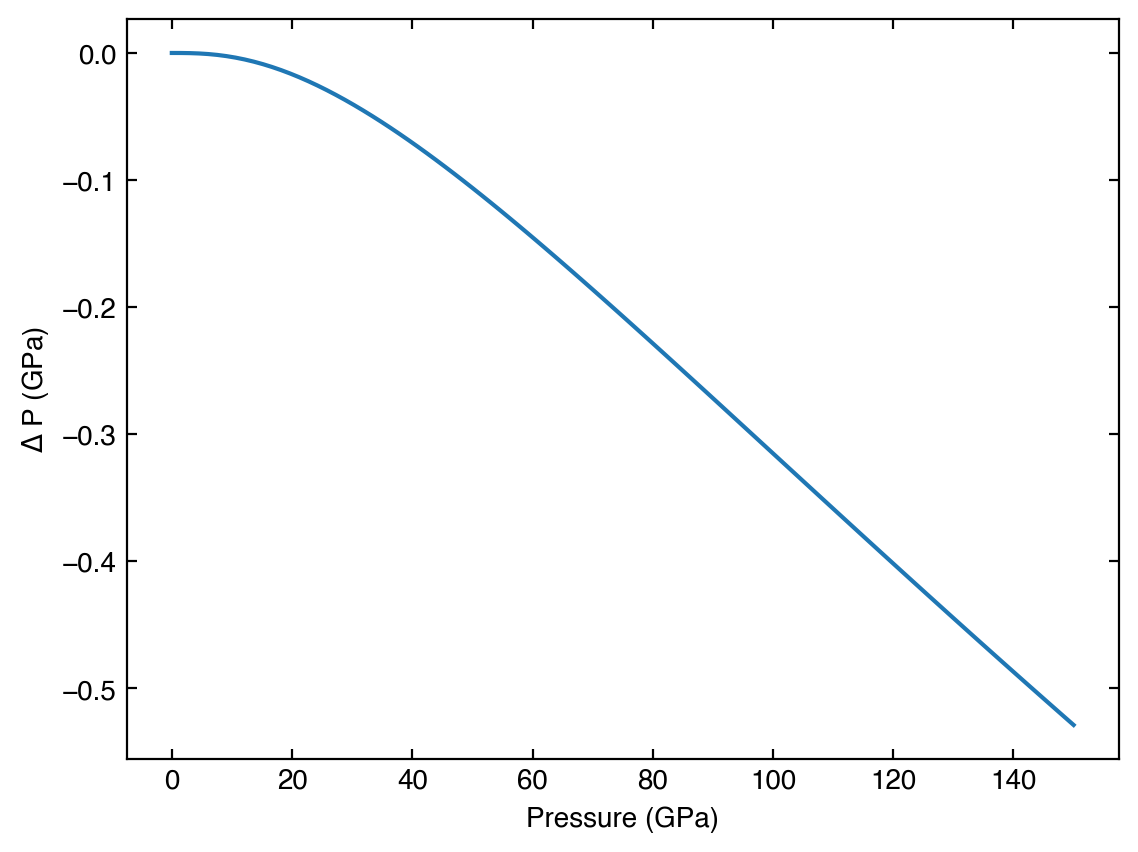

In [10]:
plt.plot(p,unp.nominal_values(v - v_bm3))
plt.xlabel('Pressure (GPa)')
plt.ylabel('$\Delta$ P (GPa)');

You will systematically underestimate pressure by using $K_0$ and $K_0'$ obtained from Vinet equation in BM3 equation.  

# 4. Can we reduce the problem?

Fit the synthetic data to get $K_0'$ for BM equation.  First, setup bm3 model.

In [11]:
model_bm3 = eos.BM3Model()

Generate parameters.  Note that `k0p` is uncertainty formatted and therefore, you need to take nominal value only by `.n`. 

In [12]:
params = model_bm3.make_params(v0=v0[standard], k0=k0[standard], k0p=k0p[standard].n)

Fix parameters.

In [13]:
params['v0'].vary = False
params['k0'].vary = False

Run fitting

In [14]:
fitresult_bm3 = model_bm3.fit(p, params, v=unp.nominal_values(v))
print(fitresult_bm3.fit_report())

[[Model]]
    Model(bm3_p)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 100
    # variables        = 1
    chi-square         = 11.4173856
    reduced chi-square = 0.11532713
    Akaike info crit   = -215.003294
    Bayesian info crit = -212.398124
    R-squared          = 0.99994031
[[Variables]]
    v0:   74.698 (fixed)
    k0:   160.3 (fixed)
    k0p:  3.92673611 +/- 0.00192722 (0.05%) (init = 4.109)


/opt/homebrew/Caskroom/miniforge/base/envs/pytheos-dev/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


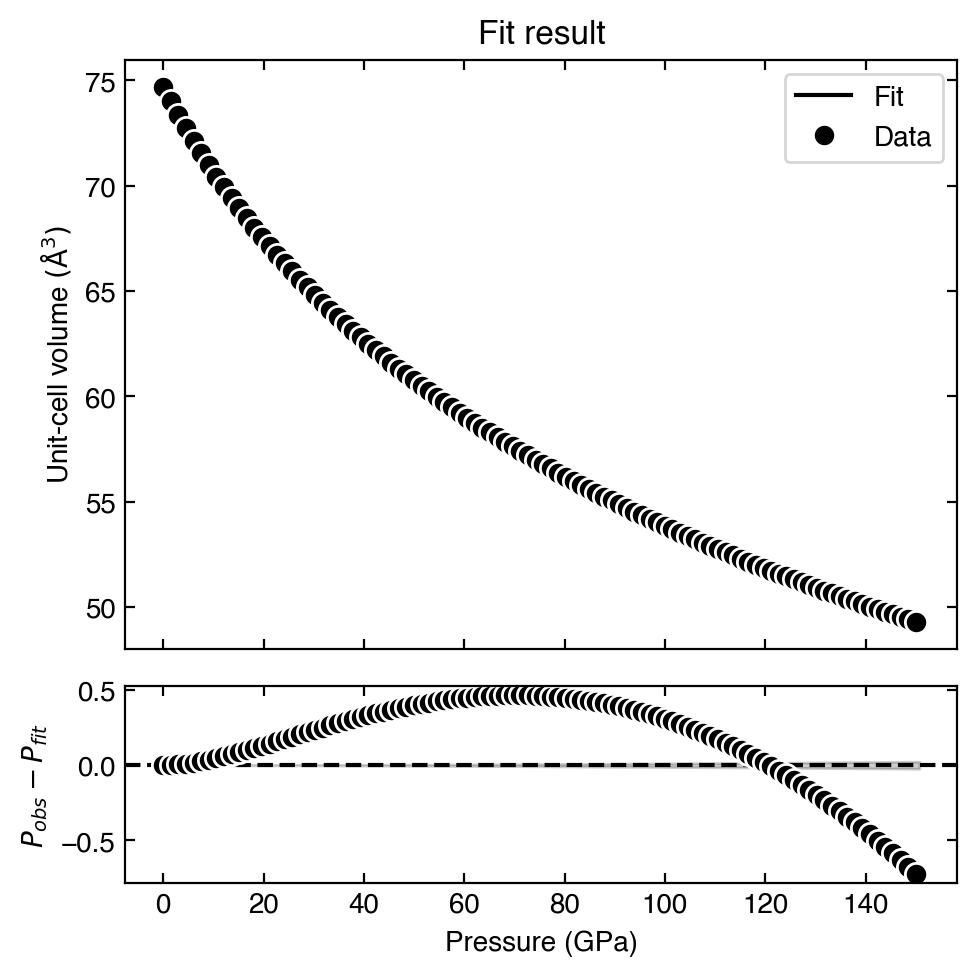

In [15]:
eos.plot.static_fit_result(fitresult_bm3)

As you can see above, there is a fundamental difference between BM3 and Vinet.  Therefore, even if you convert $K_0$ and $K_0'$ between BM3 and Vinet, it will create differences for $\pm 0.5$ GPa up to 150 GPa, for example.